In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from zipfile import ZipFile
import zipfile
import pickle
from scipy.stats import linregress
from scipy.interpolate import interp1d
import tsfel
import os
import json
import warnings
import concurrent.futures
from ensemble.config.paths import PATHS
import datetime
warnings.filterwarnings("ignore")

In [4]:
train_y = pd.read_csv(PATHS.train_y_path)
zipf_raw_train = ZipFile(PATHS.train_zip_path, 'r')


In [5]:
def process_and_shuffle_chunk(i, n_chunks):
    # Load the pickled data
    l_pkl = pickle.loads(zipf_raw_train.read(f'train_X/{train_y.filename[i]}'))
    
    # Create a DataFrame with timestamp and value
    data = pd.DataFrame({
        'timestamp': l_pkl['t'],  # Timestamp remains unchanged
        'value': l_pkl['v']
    })
    
    # Split 'value' into n_chunks parts
    value_chunks = np.array_split(data['value'], n_chunks)
    
    # Shuffle the chunks
    np.random.shuffle(value_chunks)
    
    # Concatenate the shuffled chunks back into a single series
    shuffled_values = pd.concat(value_chunks, ignore_index=True)
    
    # Recreate the DataFrame with shuffled values
    data['value'] = shuffled_values

    # Convert DataFrame back into the original pickle format
    l_pkl['v'] = data['value'].values  # Replace the original values with shuffled ones
    return l_pkl

In [17]:
shuffle_chunks = [6, 7, 8, 9, 10]
shuffle_output_base = "./processed/chunk_shuffle"
# os.makedirs(shuffle_output_base)

for c_num in shuffle_chunks:
    output_path = os.path.join(shuffle_output_base, f"train_X_shuffle_{c_num}.zip")
    # To process all files and write back to the zip
    with zipfile.ZipFile(output_path, 'a') as zipf:  # Open the zip file in append mode
        for idx in tqdm(range(len(train_y.filename)), desc=f"Shuffling with n_chunks={c_num}"):  # Adjust to your dataset
            shuffled_data = process_and_shuffle_chunk(idx, n_chunks=c_num)
            
            # Pickle and write the processed data back to the zip file
            with zipf.open(f'train_X/{train_y.filename[idx]}', 'w') as f:
                pickle.dump(shuffled_data, f)

Shuffling with n_chunks=6:  16%|█▌        | 5107/31839 [00:19<01:27, 304.65it/s]

# Check processed

In [37]:
zipf_new_train = ZipFile("./processed/chunk_shuffle/train_X_shuffle_10.zip", 'r')

In [38]:
def get_signal(i, zip_f):
    # Load the pickled data
    l_pkl = pickle.loads(zip_f.read(f'train_X/{train_y.filename[i]}'))
    
    # Create a DataFrame with timestamp and value
    data = pd.DataFrame({
        'timestamp': l_pkl['t'],  # Timestamp remains unchanged
        'value': l_pkl['v']
    })

    data['timestamp'] = data['timestamp'].dt.total_seconds()

    return data

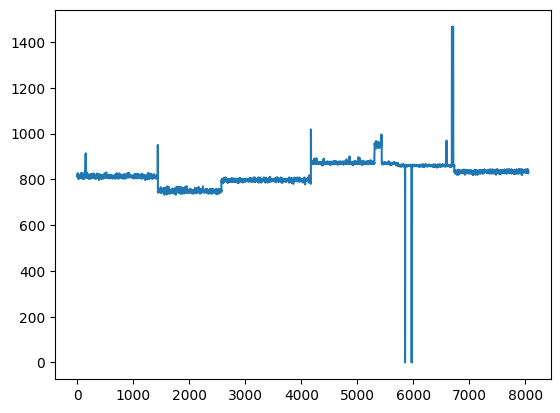

In [39]:
from matplotlib import pyplot as plt

plt.plot(get_signal(1000, zipf_raw_train)['value'])

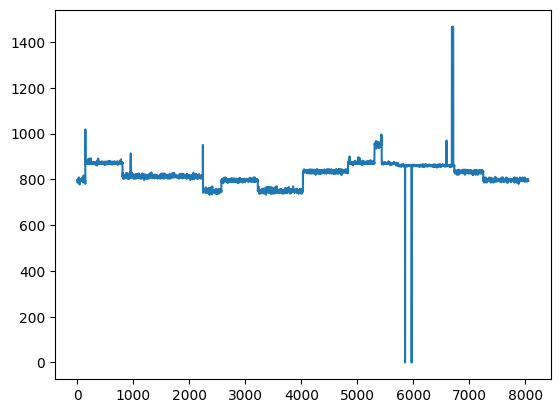

In [40]:
plt.plot(get_signal(1000, zipf_new_train)['value'])